## Analiza danych w języku Python

In [20]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

### Przygotowanie danych

Plik raw_data.csv zawiera informacje na temat erupcji wulkanów pobrane ze strony https://volcano.si.edu/.

- Tablica zawiera następujące elementy:</br>

    > Indeks: Eruption Number</br>
   
    > Kolumny: Volcano Name, Eruption Category, VEI, Start Year, Start Month, Start Day, End Year, End Month, End Day, Evidence Type, Evidence Method</br>

- Indeks tablicy jest stworzony na podstawie kolumny Eruption Number z wczytanej tablicy danych.
- Kolumny Evidence Type i Evidence Method powstały poprzez rozbicie kolumny Evidence Method (dating) zawartej w danych wejściowych na dwie osobne kolumny. Brakujące wartości w tych kolumnach (NaN) zostały zastąpione odpowiednio na 'Uncertain' i 'Unspecified'.
- Tablica nie zawiera wierszy dotyczących podważanych (ang. discredited) erupcji oraz erupcji, dla których nie została określona wartość VEI (Volcanic Explosivity Index).
- Z nazw zawartych w kolumnie Eruption Category słowo "Eruption" zostało usunięte, pozostawiając tylko poprzedzające go człony zawartych w niej określeń.
- Niektóre z erupcji mają wpisane wartości miesiąca i dnia ich początku lub końca jako 0, te wartości zostały zmienione na NaN.

Wyświetlane jest pierwsze i ostatnie 10 pierwszych wierszy, z liczbami zaokrąglonymi do całości

In [16]:
dane = pd.read_csv("raw_data.csv", header=1)

dane = dane.set_index("Eruption Number", drop = False)

eruptions_data = dane[["Volcano Name", "Eruption Category", "VEI", "Start Year", "Start Month", "Start Day", "End Year", "End Month", "End Day"]].copy()
eruptions_data[["Evidence Type", "Evidence Method"]] = dane["Evidence Method (dating)"].str.split(": ", expand=True)

eruptions_data["Evidence Type"] = eruptions_data["Evidence Type"].fillna("Uncertain")
eruptions_data["Evidence Method"] = eruptions_data["Evidence Method"].fillna("Unspecified")

eruptions_data = eruptions_data.loc[eruptions_data["VEI"].notna()]
eruptions_data = eruptions_data.loc[eruptions_data["Eruption Category"] != "Discredited Eruption"]

eruptions_data["Eruption Category"] = eruptions_data["Eruption Category"].str.replace(" Eruption", "", regex=False)
eruptions_data[["Start Month", "Start Day", "End Month", "End Day"]] = eruptions_data[["Start Month", "Start Day", "End Month", "End Day"]].replace(0.0, np.nan)

eruptions_data.style.format( precision=0 ).hide(axis='index', subset=eruptions_data.index[10:-10])

,Volcano Name,Eruption Category,VEI,Start Year,Start Month,Start Day,End Year,End Month,End Day,Evidence Type,Evidence Method
Eruption Number,,,,,,,,,,,
22486,Cotopaxi,Confirmed,2,2022,10,21,2022,12,19,Observations,Reported
22481,Taal,Confirmed,1,2022,10,5,2022,10,29,Observations,Reported
22458,Turrialba,Confirmed,1,2022,7,17,2022,7,17,Observations,Reported
22453,Ulawun,Confirmed,2,2022,6,2,2022,6,2,Observations,Reported
22454,Raung,Confirmed,2,2022,5,14,2022,9,27,Observations,Satellite (infrared)
22445,Gaua,Confirmed,1,2022,5,3,2022,5,3,Observations,Reported
22451,Purace,Confirmed,1,2022,3,29,2022,3,29,Observations,Reported
22430,Ambrym,Confirmed,1,2022,1,25,2022,2,2,Observations,Reported
22456,Chikurachki,Confirmed,2,2022,1,17,2022,10,17,Observations,Satellite (visual)


### Przegląd danych

#### 1) Największe erupcje
Wiersze tablicy `eruptions_data` dotyczące erupcji, którym została przyporządkowana wartość VEI równa 7.

In [17]:
eruptions_data[eruptions_data["VEI"] == 7]

,Volcano Name,Eruption Category,VEI,Start Year,Start Month,Start Day,End Year,End Month,End Day,Evidence Type,Evidence Method
Eruption Number,,,,,,,,,,,
16231,Tambora,Confirmed,7,1812,NaN,NaN,1815,7,15,Observations,Reported
20843,Rinjani,Confirmed,7,1257,7,1,NaN,NaN,NaN,Sidereal,Ice Core
13879,Santorini,Confirmed,7,-1610,NaN,NaN,NaN,NaN,NaN,Isotopic,14C (calibrated)
20904,"Blanco, Cerro",Confirmed,7,-2300,NaN,NaN,NaN,NaN,NaN,Isotopic,14C (calibrated)
16980,Kikai,Confirmed,7,-4350,NaN,NaN,NaN,NaN,NaN,Isotopic,14C (uncalibrated)
20610,Crater Lake,Confirmed,7,-5680,NaN,NaN,NaN,NaN,NaN,Sidereal,Ice Core
18903,Kurile Lake,Confirmed,7,-6440,NaN,NaN,NaN,NaN,NaN,Isotopic,14C (calibrated)


#### b) Najaktywniejsze wulkany
Tablica `most_active_data` zawiera następujące elementy:

> Indeks: </br>
> Domyślny indeksowanie tablicy

> Kolumny: Volcano, Recorded eruptions </br>
> Kolumny zawierające nazwy wulkanów oraz liczby zarejestrowanych erupcji.

Dane w tablicy są posortowane od największej do najmniejszej liczby zarejestrowanych erupcji, a w przypadku takiej samej liczby erupcji alfabetycznie po nazwach wulkanów.

Wyświetlane jest pierwsze 10 pierwszych wierszy:

In [18]:
most_active_data = eruptions_data["Volcano Name"].value_counts()
most_active_data = most_active_data.reset_index()
most_active_data.columns = ["Volcano", "Recorded eruptions"]
most_active_data = most_active_data.sort_values(by=["Recorded eruptions","Volcano"], ascending=[False, True])

most_active_data.head(10)

,Volcano,Recorded eruptions
0,"Fournaise, Piton de la",191
1,Asosan,180
2,Villarrica,152
3,Asamayama,128
4,Etna,121
5,Mauna Loa,110
6,Klyuchevskoy,104
7,Sheveluch,102
8,Gamalama,81
9,Merapi,81


#### c) Ostatnie erupcje o określonej wielkości
Tablica `last_eruption_data` zawiera następujące elementy:

> Indeks: VEI </br>
> Wartości VEI posortowane od najmniejszej do największej.

> Kolumny: Last recorded eruption </br>
> Lata, w których ostatni raz zarejestrowano erupcję o określonej wartości VEI (na podstawie daty początku erupcji).

In [19]:
last_eruption_data = eruptions_data.groupby("VEI")
last_eruption_data = last_eruption_data.max("Start Year")[["Start Year"]]
pd.options.display.float_format = '{:.0f}'.format
last_eruption_data.columns = ["Last recorded eruption"]
last_eruption_data

,Last recorded eruption
VEI,
0,2021
1,2022
2,2022
3,2021
4,2021
5,2021
6,1991
7,1812


### Konstrukcja szeregów rodzielczych
#### Forma tabelaryczna

> Indeks: VEI </br>
> Wartości VEI posortowane od najmniejszej do największej.

> Kolumny: 2-poziomowe nagłówki

>> Nagłówki 1 poziomu: All, Confirmed Eruption, Uncertain Eruption </br>
>> Wyznaczone na podstawie kolumny Eruption category</br>

>> Nagłówki 2 poziomu: f, cf, rf, crf </br>
>> f - zliczenia poszczególnych kategorii (ang. frequency, absolute frequency), cf - zliczenia skumulowane poszczególnych kategorii (ang. cumulative frequency, cumulative absolute frequency),  rf - częstość zliczeń poszczególnych kategorii (ang. relative frequency), crf - skumulowana częstość zliczeń poszczególnych kategorii (ang. cumulative relative frequency)

In [24]:
vei_data_1 = eruptions_data["VEI"].value_counts()
vei_data_1 = pd.DataFrame(vei_data_1)
vei_data_1.columns = ["f"]
vei_data_1 = vei_data_1.sort_index()

vei_data_1['cf'] = np.cumsum(vei_data_1['f'])

max_f = vei_data_1.loc[7, 'cf']
vei_data_1['rf'] = vei_data_1['f']/max_f

vei_data_1['crf'] = np.cumsum(vei_data_1['rf'])

eruptions_data_c = eruptions_data.loc[eruptions_data["Eruption Category"] == "Confirmed"]

vei_data_2 = eruptions_data_c["VEI"].value_counts()
vei_data_2 = pd.DataFrame(vei_data_2)
vei_data_2.columns = ["f"]
vei_data_2 = vei_data_2.sort_index()

vei_data_2['cf'] = np.cumsum(vei_data_2['f'])

max_f = vei_data_2.loc[7, 'cf']
vei_data_2['rf'] = vei_data_2['f']/max_f

vei_data_2['crf'] = np.cumsum(vei_data_2['rf'])

eruptions_data_c = eruptions_data.loc[eruptions_data["Eruption Category"] == "Uncertain"]

vei_data_3 = eruptions_data_c["VEI"].value_counts()
vei_data_3 = pd.DataFrame(vei_data_3)
vei_data_3.columns = ["f"]
vei_data_3 = vei_data_3.sort_index()

vei_data_3['cf'] = np.cumsum(vei_data_3['f'])

max_f = vei_data_3.loc[4, 'cf']
vei_data_3['rf'] = vei_data_3['f']/max_f

vei_data_3['crf'] = np.cumsum(vei_data_3['rf'])

vei_data = pd.concat([vei_data_1, vei_data_2, vei_data_3], axis=1, keys=["All eruptions", "Confirmed Eruptions", "Uncertain Eruptions"])

vei_data.style.format(
    {("All eruptions","rf"): '{:.4f}',
    ("All eruptions","crf"): '{:.4f}',
    ("Confirmed Eruptions","rf"): '{:.4f}',
    ("Confirmed Eruptions","crf"): '{:.4f}',
    ("Uncertain Eruptions","f"): '{:.0f}',
    ("Uncertain Eruptions","cf"): '{:.0f}',
    ("Uncertain Eruptions","rf"): '{:.4f}',
    ("Uncertain Eruptions","crf"): '{:.4f}'}
).format_index(precision=0)

#### Forma graficzna
Wykresy słupkowe zliczeń (lewa oś wykresu) z nałożonymi na nie łamanymi częstości skumulowanej (prawa oś wykresu). Dodatkowo:
- identyczne zakresy wartości na odpowiadających sobie osiach wszystkich trzech wykresów,
- kolory lewej i prawej osi oraz ich opisów identyczne z kolorem elementu wykresu, którego dotyczą,
- format wyświetlania wartości VEI bez miejsc po przecinku.

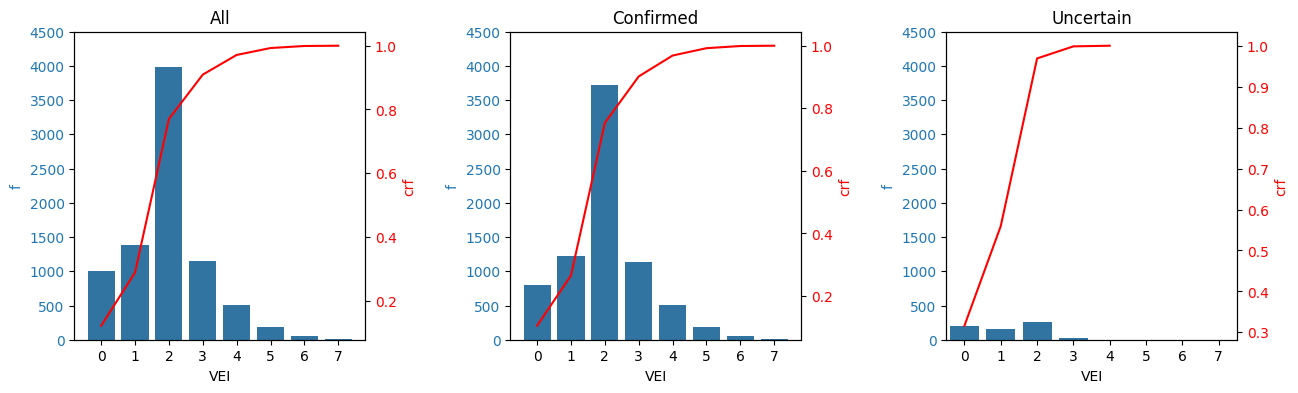

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), facecolor="white")

sns.barplot(data=vei_data["All eruptions"], ax=axes[0], x="VEI", y="f")
axes[0].set_title("All")
axes[0].set_xlabel("VEI")
axes[0].set_ylabel("f", color = '#1f77b4')
axes[0].tick_params(axis='y', labelcolor='#1f77b4')
axes[0].set_ylim(0, 4500)
axes[0].set_xticks(list(range(0,8)))
axes[0].set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7])

ax0 = axes[0].twinx()  # Tworzymy drugą oś Y
ax0.plot(vei_data_1.index, vei_data_1["crf"], 'r-')
ax0.set_ylabel('crf', color='r')
ax0.tick_params(axis='y', labelcolor='r')

sns.barplot(data=vei_data["Confirmed Eruptions"], ax=axes[1], x="VEI", y="f")
axes[1].set_title("Confirmed")
axes[1].set_xlabel("VEI")
axes[1].set_ylabel("f", color = '#1f77b4')
axes[1].tick_params(axis='y', labelcolor='#1f77b4')
axes[1].set_ylim(0, 4500)
axes[1].set_xticks(list(range(0,8)))
axes[1].set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7])

ax1 = axes[1].twinx()  # Tworzymy drugą oś Y
ax1.plot(vei_data_2.index, vei_data_2["crf"], 'r-')
ax1.set_ylabel('crf', color='r')
ax1.tick_params(axis='y', labelcolor='r')

sns.barplot(data=vei_data["Uncertain Eruptions"], ax=axes[2], x="VEI", y="f")
axes[2].set_title("Uncertain")
axes[2].set_xlabel("VEI")
axes[2].set_ylabel("f", color = '#1f77b4')
axes[2].tick_params(axis='y', labelcolor='#1f77b4')
axes[2].set_ylim(0, 4500)
axes[2].set_xlim(-0.5, 7.5)
axes[2].set_xticks(list(range(0,8)))
axes[2].set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7])

ax2 = axes[2].twinx()  # Tworzymy drugą oś Y
ax2.plot(vei_data_3.index, vei_data_3["crf"], 'r-')
ax2.set_ylabel('crf', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.subplots_adjust(wspace=0.5)
plt.show()

### Rodzaje metod wykrywania erupcji

Tablica `evidence_data` zawiara informacje o tym ile erupcji o poszczególnych wartościach VEI zostało potwierdzonych przy użyciu poszczególnych metod weryfikacji.
Tablica zawiera następujące elementy:

> Indeks: 2-poziomowe nagłówki </br>

>> Nagłówki 1 poziomu: Kategorie dowodów </br>

>> Nagłówki 2 poziomu: Metody, które dostarczyły dowodów </br>

> Kolumny: VEI </br>
> Wartości VEI posortowane od najmniejszej do największej oraz kolumna "All", w której znajdują się dane dotyczące wszystkich erupcji, bez podziału na VEI.

In [22]:
buffor = eruptions_data[["VEI",'Evidence Type', 'Evidence Method' ]].copy()
evidence_data = pd.pivot_table(buffor,
                               index=['Evidence Type', 'Evidence Method'],
                               columns=['VEI'],
                               aggfunc='size',
                               fill_value=0
                              )
evidence_data.columns = evidence_data.columns.astype(int)
evidence_data["All"] = evidence_data.sum(axis=1)

evidence_data.style.set_table_styles([
     {'selector': 'td', 'props': [('border', '1px solid black')]},  # obramowanie dla komórek
     {'selector': 'th', 'props': [('border', '1px solid black')]}  # obramowanie dla nagłówków
])

### Wizualizacja rozkładu zarejestrowanych erupcji w czasie

Wizualizacja jak rozkładały się w czasie wystąpienia zarejestrowanych erupcji. Do rozróżnienia erupcji w czasie wykorzystywany jest rok, w którym nastąpił ich początek.

Na górnym wykresie przedstawiono dane rozróżnione tylko po kątem VEI, a na dolnym wykresie przedstaw dane rozróżnione zarówno po VEI jak i rodzaju dowodu ich wystąpienia (Evidence Type). Dodatkowo:

- format wyświetlania wartości VEI bez miejsc po przecinku.

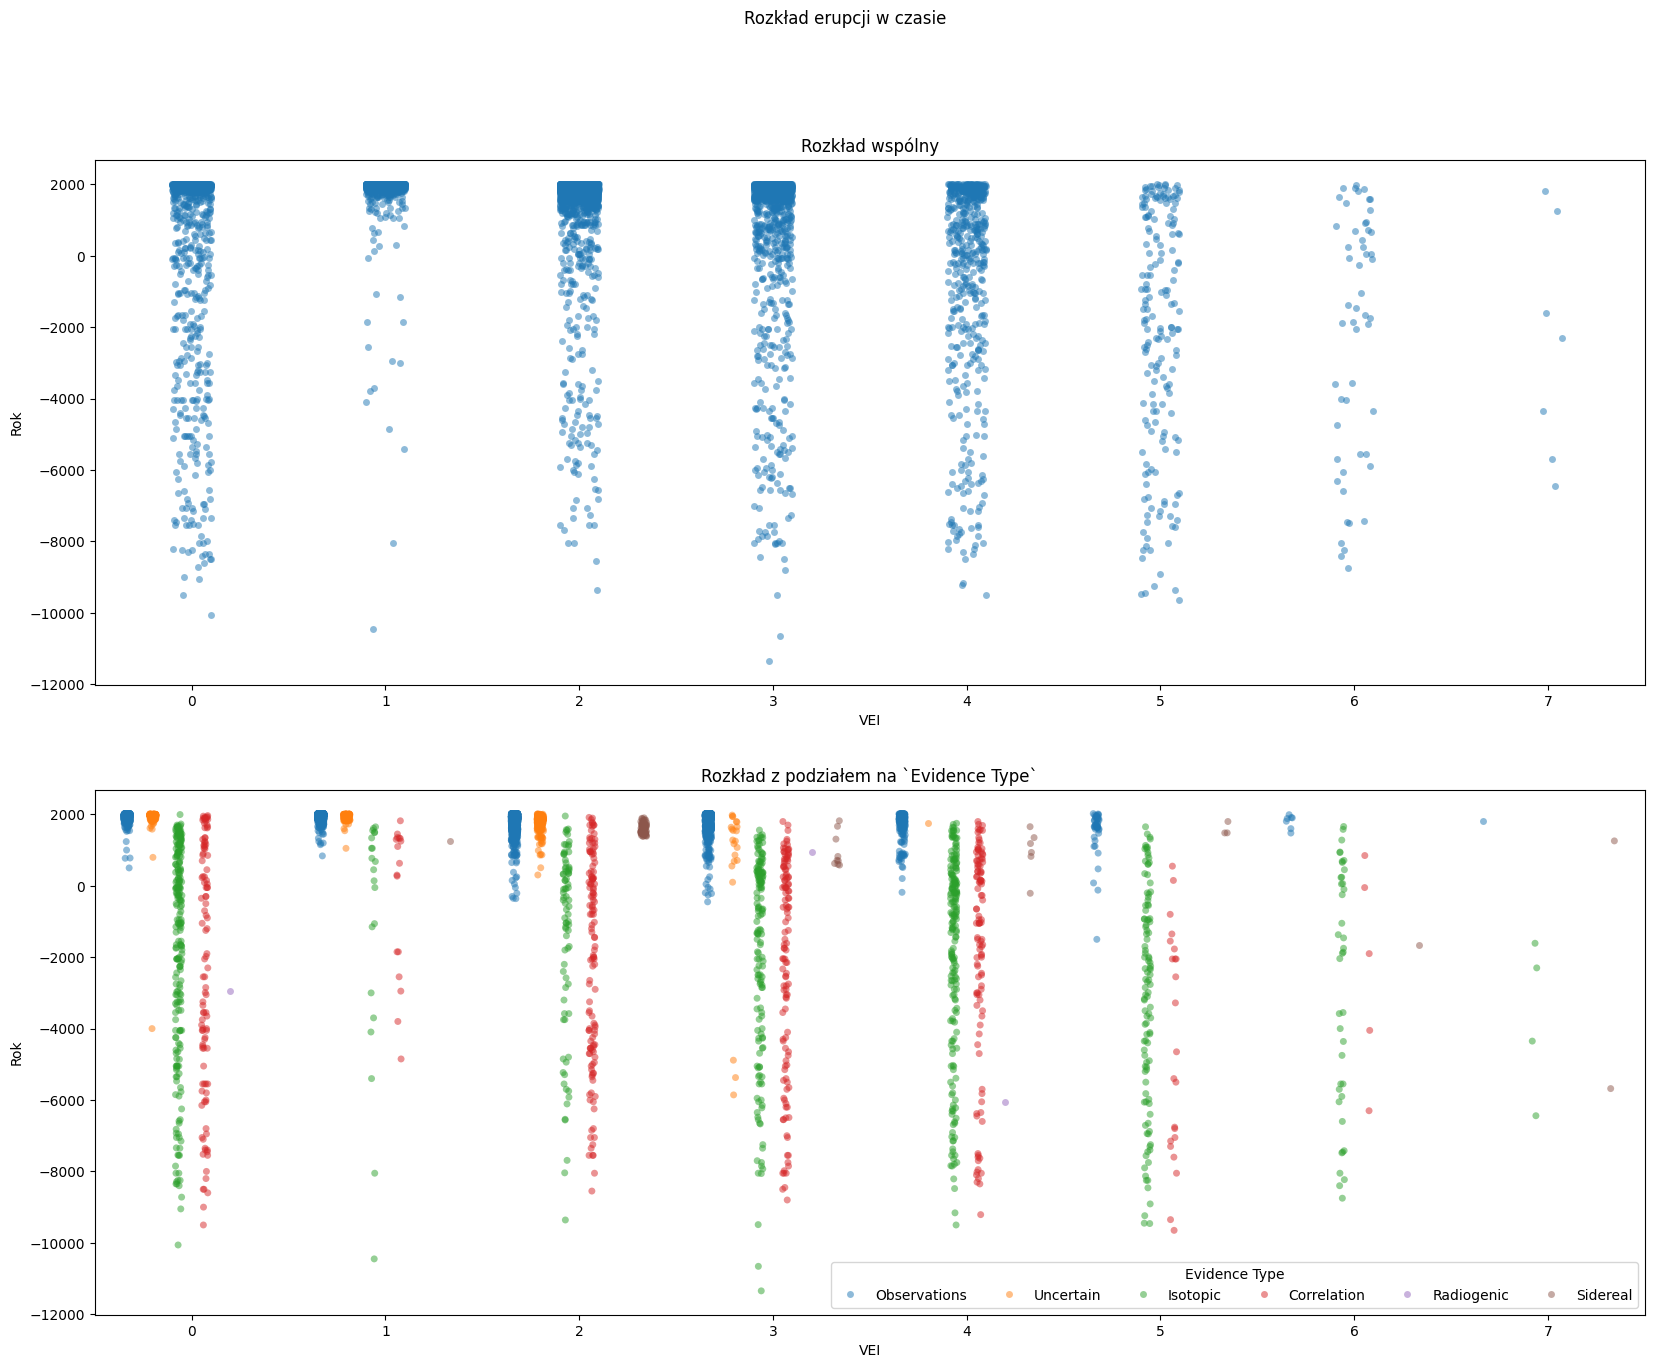

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 15), facecolor="white")
fig.suptitle("Rozkład erupcji w czasie")

sns.stripplot(data=eruptions_data, ax=axes[0], x="VEI", y="Start Year", alpha=0.5)
axes[0].set_title("Rozkład wspólny")
axes[0].set_xlabel("VEI")
axes[0].set_ylabel("Rok")
axes[0].set_xticks(list(range(0,8)))
axes[0].set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7])

sns.stripplot(data=eruptions_data, ax=axes[1], x="VEI", y="Start Year", alpha=0.5, hue="Evidence Type", dodge=True)
axes[1].set_title("Rozkład z podziałem na `Evidence Type`")
axes[1].set_xlabel("VEI")
axes[1].set_ylabel("Rok")
axes[1].legend(loc='lower right', ncol=6, title='Evidence Type')
axes[1].set_xticks(list(range(0,8)))
axes[1].set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7])

plt.show()